In [36]:
import torch
import dataset
import models
import utils
import numpy as np
from torchvision import transforms
from train_test import train, test

In [2]:
cuda, device = utils.others.initialize_device(utils.config.SEED)

GPU Available? True


In [3]:
trainset = dataset.pytorch_datasets(True, True, dataset_name='cifar10')
testset = dataset.pytorch_datasets(False, True, dataset_name='cifar10')

Files already downloaded and verified
Files already downloaded and verified


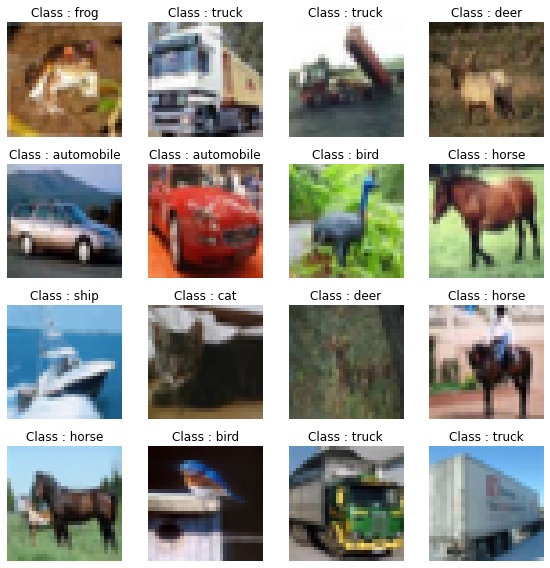

In [4]:
utils.visualization.show_imgs(trainset, 16, (8, 8))

In [6]:
mean, std = utils.img_reg.get_stats(trainset)[0], utils.img_reg.get_stats(trainset)[1]
print(mean, std)

(0.4914, 0.4822, 0.4465) (0.247, 0.2435, 0.2616)


In [7]:
transformations_list = [transforms.Normalize(mean, std)]
augmentations_list = [transforms.RandomRotation(7), 
                      transforms.RandomHorizontalFlip(0.3)]

In [8]:
trainset = dataset.pytorch_datasets(True, True, transformations_list, augmentations_list, dataset_name='cifar10')
testset = dataset.pytorch_datasets(False, True, transformations_list, dataset_name='cifar10')
train_dl = dataset.data_loader(trainset, utils.config.BATCH_SIZE, utils.config.NUM_WORKERS, cuda, shuffle=True)
test_dl = dataset.data_loader(testset, utils.config.BATCH_SIZE, utils.config.NUM_WORKERS, cuda, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


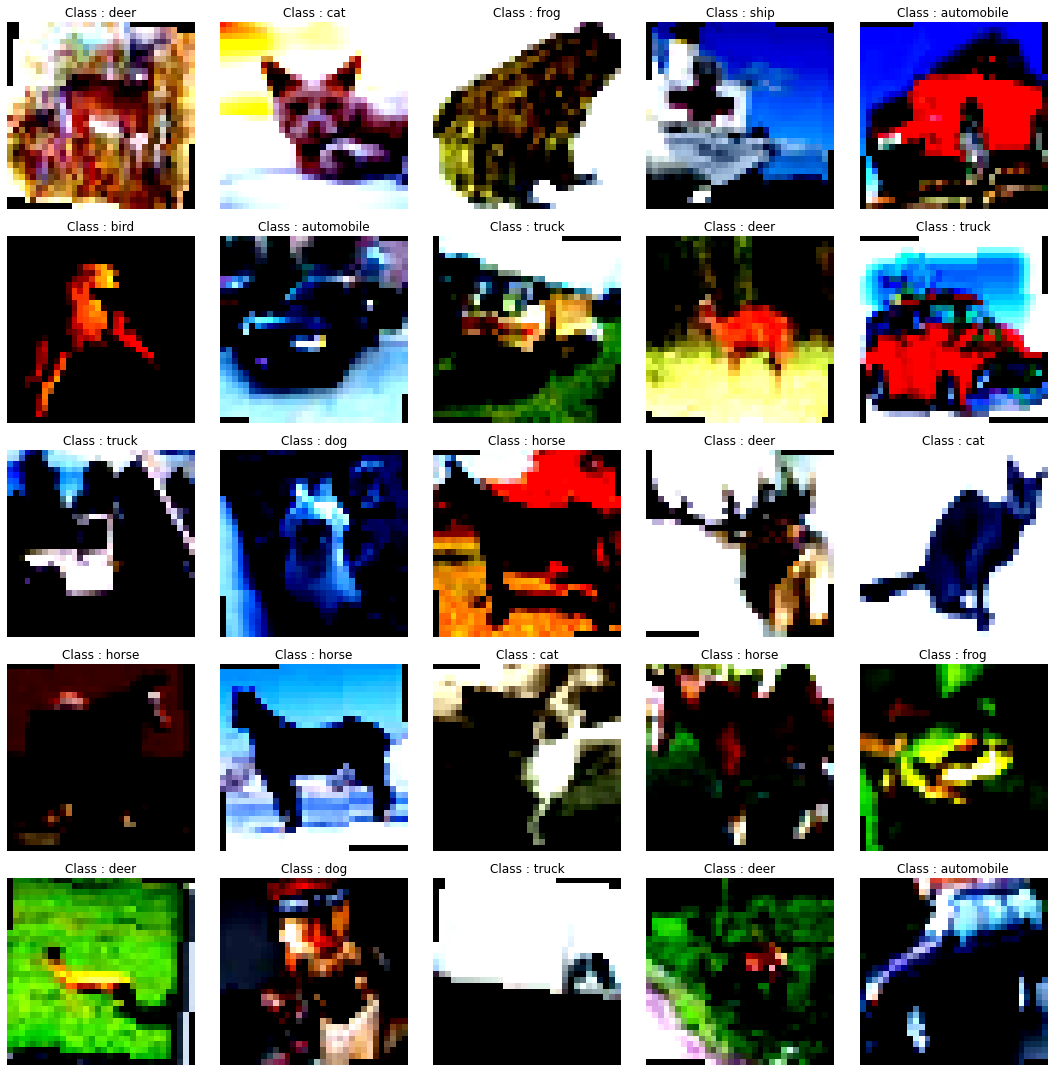

In [9]:
utils.visualization.show_batch(train_dl)

In [10]:
#Define model
model = models.ResNet18().to(device)

In [11]:
utils.others.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [12]:
utils.config.EPOCHS

1

In [14]:
model = models.ResNet18().to(device)
loss_fn = utils.others.cross_entropy_loss_fn()
optimizer = utils.others.sgd_optimizer(model)
scheduler = utils.others.StepLR_scheduler(optimizer, step_size=6)
if utils.config.DEBUG == True:
    utils.config.EPOCHS = 1

test_loss = []
test_accuracy = []
train_losses = []
train_accuracy = []
misclassified_imgs = []
for epoch in range(utils.config.EPOCHS):
    print(f"Running Epoch {epoch+1}/{utils.config.EPOCHS}\n")
    train(model, train_dl, optimizer, loss_fn, device, train_losses, train_accuracy)
    scheduler.step()
    test(model, test_dl, loss_fn, device, 25, test_loss, test_accuracy, misclassified_imgs)

  0%|                                                                                         | 0/1563 [00:00<?, ?it/s]

Running Epoch 1/1



Loss=1.24 Batch_ID=1562 Accuracy=47.05: 100%|██████████████████████████████████████| 1563/1563 [04:54<00:00,  5.31it/s]



Validation set: Average loss: 0.0355, Accuracy: 6057/10000 (60.57%)



In [41]:
import matplotlib.pyplot as plt
import cv2

def idx_to_class(class_to_idx):
    return {v: k for k, v in list(class_to_idx.items())}

def show_grad_cam(model,dataloader):
    bs = dataloader.batch_size
    num_samples = dataloader.dataset.data.shape[0]
    batches = num_samples // bs
    batch_id = np.random.choice(batches)
    one_batch = list(dataloader)[batch_id]
    batch_imgs, batch_labels = one_batch[0], one_batch[1]
    print(batch_imgs)
    grad_cam = utils.grad_cam.GradCam(model=model, feature_module=model.layer4, \
                       target_layer_names=["2"], use_cuda=False)
    class_idx = dataloader.dataset.class_to_idx
    idx_class = idx_to_class(class_idx)
    n_rows = n_cols = int(np.sqrt(len(batch_imgs)))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    if batch_imgs.shape[1] == 1:
        cmap = 'gray'
    else:
        cmap = None
    for img,label in zip(batch_imgs,batch_labels):
        img = np.clip(img.squeeze().permute(1, 2, 0).numpy(), 0, 1)
        img = np.float32(cv2.resize(img, (224, 224)))
        input = utils.grad_cam.preprocess_image(img)

        # If None, returns the map for the highest scoring category.
        # Otherwise, targets the requested index.
        target_index = None
        mask = grad_cam(input, target_index)
        show_cam_on_image(img, mask)

        gb_model = utils.grad_cam.GuidedBackpropReLUModel(model=model, use_cuda=args.use_cuda)
        print(model._modules.items())
        gb = gb_model(input, index=target_index)
        gb = gb.transpose((1, 2, 0))
        cam_mask = cv2.merge([mask, mask, mask])
        cam_gb = deprocess_image(cam_mask * gb)
        gb = deprocess_image(gb)

        cv2.imshow(f'gb : {idx_class[label.item()]}', gb)
        cv2.imshow(f'cam_gb : {idx_class[label.item()]}', cam_gb)

tensor([[[[-0.0366,  0.1063,  0.2333,  ...,  0.4714,  0.3444,  0.0110],
          [-0.0049,  0.1221,  0.2492,  ...,  0.4556,  0.3285,  0.0586],
          [-0.0049,  0.1221,  0.2174,  ...,  0.3603,  0.2015, -0.0684],
          ...,
          [-1.1480, -1.0686, -0.7035,  ..., -0.0843, -0.3542, -0.5129],
          [-1.2433, -1.1639, -0.9099,  ..., -0.2113, -0.4018, -0.5764],
          [-1.1163, -1.1004, -1.0051,  ..., -0.3859, -0.4177, -0.6876]],

         [[-0.0316,  0.1134,  0.2583,  ...,  0.4194,  0.3066, -0.0477],
          [-0.0155,  0.1295,  0.2583,  ...,  0.3871,  0.2583, -0.0316],
          [-0.0477,  0.0812,  0.1939,  ...,  0.2905,  0.1134, -0.1765],
          ...,
          [-1.2395, -1.1267, -0.8368,  ..., -0.2409, -0.4825, -0.6114],
          [-1.4005, -1.2878, -1.0945,  ..., -0.3537, -0.5308, -0.6758],
          [-1.3200, -1.2878, -1.2395,  ..., -0.4986, -0.5308, -0.7885]],

         [[ 0.1520,  0.2420,  0.3319,  ...,  0.4069,  0.3319,  0.0471],
          [ 0.1520,  0.2420,  

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

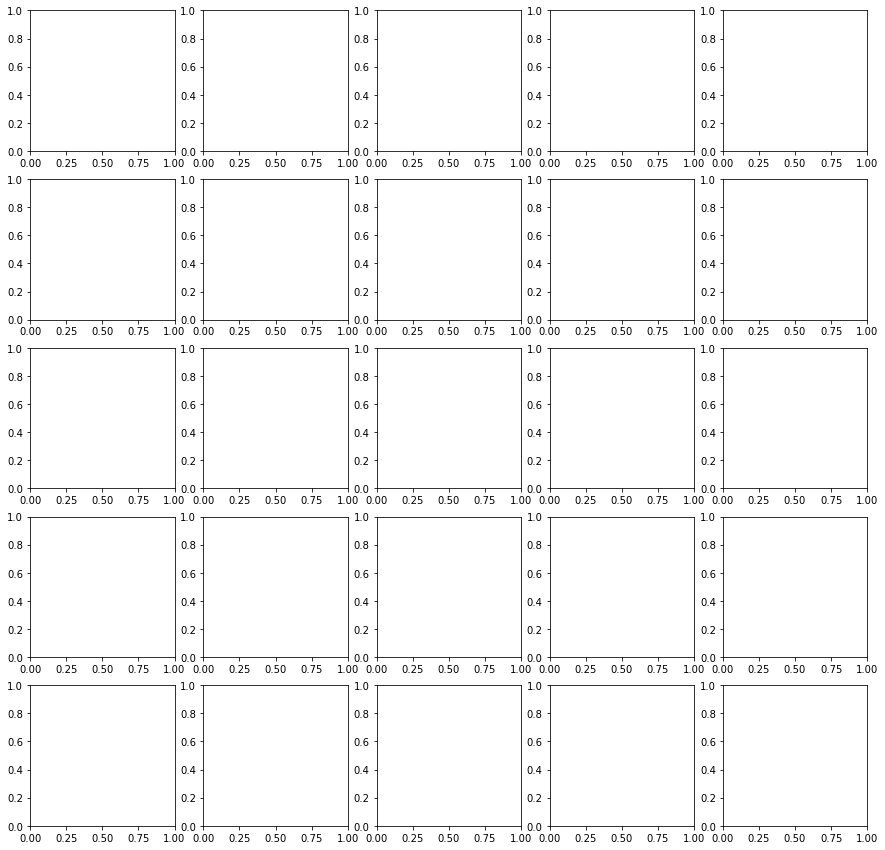

In [42]:
show_grad_cam(model,test_dl)

In [46]:
class GradCam:
    def __init__(self, model, layers):
        self.model = model
        self.layers = layers
        self.hooks = []
        self.fmap_pool = dict()
        self.grad_pool = dict()

        def forward_hook(module, input, output):
            self.fmap_pool[module] = output.detach().cpu()
        def backward_hook(module, grad_in, grad_out):
            self.grad_pool[module] = grad_out[0].detach().cpu()
        
        for layer in layers:
            self.hooks.append(layer.register_forward_hook(forward_hook))
            self.hooks.append(layer.register_backward_hook(backward_hook))

    def close(self):
        for hook in self.hooks:
            hook.remove()

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        self.close()

    def __call__(self, *args, **kwargs):
        self.model.zero_grad()
        return self.model(*args, **kwargs)

    def get(self, layer):
        assert layer in self.layers, f'{layer} not in {self.layers}'
        fmap_b = self.fmap_pool[layer] # [N, C, fmpH, fmpW]
        grad_b = self.grad_pool[layer] # [N, C, fmpH, fmpW]

        grad_b = F.adaptive_avg_pool2d(grad_b, (1, 1)) # [N, C, 1, 1]
        gcam_b = (fmap_b * grad_b).sum(dim=1, keepdim=True) # [N, 1, fmpH, fmpW]
        gcam_b = F.relu(gcam_b)

        return gcam_b

In [141]:
class GuidedBackPropogation:
    def __init__(self, model):
        self.model = model
        self.hooks = []

        def backward_hook(module, grad_in, grad_out):
            if isinstance(module, nn.ReLU):
                return tuple(grad.clamp(min=0.0) for grad in grad_in)

        for name, module in self.model.named_modules():
            self.hooks.append(module.register_backward_hook(backward_hook))

    def close(self):
        for hook in self.hooks:
            hook.remove()

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        self.close()

    def __call__(self, *args, **kwargs):
        self.model.zero_grad()
        return self.model(*args, **kwargs)
    
    def get(self, layer):
        return layer.grad.cpu()

In [142]:
def colorize(tensor, colormap=plt.cm.jet):
    '''Apply colormap to tensor
    Args:
        tensor: (FloatTensor), sized [N, 1, H, W]
        colormap: (plt.cm.*)
    Return:
        tensor: (FloatTensor), sized [N, 3, H, W]
    '''
    tensor = tensor.clamp(min=0.0)
    tensor = tensor.squeeze(dim=1).numpy() # [N, H, W]
    tensor = colormap(tensor)[..., :3] # [N, H, W, 3]
    tensor = torch.from_numpy(tensor).float()
    tensor = tensor.permute(0, 3, 1, 2) # [N, 3, H, W]
    return tensor

def normalize(tensor, eps=1e-8):
    '''Normalize each tensor in mini-batch like Min-Max Scaler
    Args:
        tensor: (FloatTensor), sized [N, C, H, W]
    Return:
        tensor: (FloatTensor) ranged [0, 1], sized [N, C, H, W]
    '''
    N = tensor.size(0)
    min_val = tensor.contiguous().view(N, -1).min(dim=1)[0]
    tensor = tensor - min_val.view(N, 1, 1, 1)
    max_val = tensor.contiguous().view(N, -1).max(dim=1)[0]
    tensor = tensor / (max_val + eps).view(N, 1, 1, 1)
    return tensor

In [146]:
def draw_gad_cam(model,device,dataloader):
    model.eval()
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    for img, lbl in zip(images,labels):
        inp_b = img.unsqueeze(dim=0) # [N, 3, 224, 224]
        inp_b = inp_b.to(device)
        
        with GradCam(model, [model.layer4]) as gcam:
            out_b = gcam(inp_b) # [N, C]
            out_b[:, labels[0]].backward()

            gcam_b = gcam.get(model.layer4) # [N, 1, fmpH, fmpW]
            gcam_b = F.interpolate(gcam_b, [32, 32], mode='bilinear', align_corners=False) # [N, 1, inpH, inpW]
            save_image(normalize(gcam_b), './gcam.png')


        with GuidedBackPropogation(model) as gdbp:
            inp_b = inp_b.requires_grad_() # Enable recording inp_b's gradient
            out_b = gdbp(inp_b)
            out_b[:, labels[0]].backward()

            grad_b = gdbp.get(inp_b) # [N, 3, inpH, inpW]
            grad_b = grad_b.mean(dim=1, keepdim=True) # [N, 1, inpH, inpW]
            save_image(normalize(grad_b), './grad.png')
            
        mixed = gcam_b * grad_b
        heatmap = normalize(mixed)
        img = img / 2 + 0.49139968     # unnormalize
        npimg = img.numpy()
        
        ## plotting the image and gradmap
        f, axarr = plt.subplots(nrows=1,ncols=2)
        plt.sca(axarr[0]); 
        plt.imshow(heatmap.squeeze()); plt.title('image')
        plt.sca(axarr[1]);
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        # plt.imshow(img); 
        plt.title('grad_cam')
        plt.show()

In [147]:
draw_gad_cam(model,device,test_dl)

BrokenPipeError: [Errno 32] Broken pipe

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


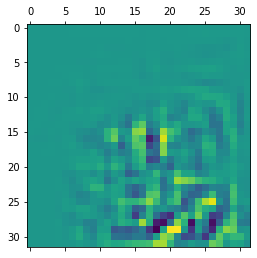

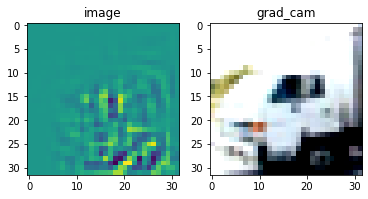

In [128]:
import random

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.utils import save_image
from torchvision.models import densenet121
from torchvision.transforms import functional as tf

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda')
model = model
model.eval()

dataiter = iter(test_dl)
images, labels = dataiter.next()
img = images[0]

# img = Image.open('./samples/cat_dog.png')
# img = img.resize((224, 224))
# img = tf.to_tensor(img) # [3, 224, 224]
# img = tf.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

inp_b = img.unsqueeze(dim=0) # [N, 3, 224, 224]
inp_b = inp_b.to(device)

# 243: boxer
# 283: tiger cat
# grad_b = torch.zeros_like(out_b, device=device)
# grad_b[:, out_b.argmax(dim=1)] = +1.0
# out_b.backward(gradient=grad_b)

with GradCam(model, [model.layer4]) as gcam:
    out_b = gcam(inp_b) # [N, C]
    out_b[:, labels[0]].backward()

    gcam_b = gcam.get(model.layer4) # [N, 1, fmpH, fmpW]
    gcam_b = F.interpolate(gcam_b, [32, 32], mode='bilinear', align_corners=False) # [N, 1, inpH, inpW]
    save_image(normalize(gcam_b), './gcam.png')


with GuidedBackPropogation(model) as gdbp:
    inp_b = inp_b.requires_grad_() # Enable recording inp_b's gradient
    out_b = gdbp(inp_b)
    out_b[:, labels[0]].backward()

    grad_b = gdbp.get(inp_b) # [N, 3, inpH, inpW]
    grad_b = grad_b.mean(dim=1, keepdim=True) # [N, 1, inpH, inpW]
    save_image(normalize(grad_b), './grad.png')


mixed = gcam_b * grad_b
heatmap = normalize(mixed)
img = img / 2 + 0.49139968     # unnormalize
npimg = img.numpy()
# colorized = colorize(mixed)
# save_image(mixed, './mixed.png')
# plt.matshow(heatmap.squeeze())

# plt.show()
# # heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# heatmap = np.uint8(255 * heatmap)
# np.uint8(img)
# superimposed_img = heatmap * 0.4 + img.numpy()
# trans = transforms.ToPILImage()
# plt.imshow(trans(superimposed_img[0]))
# # cv2.imwrite('./map.jpg', superimposed_img)

f, axarr = plt.subplots(nrows=1,ncols=2)
plt.sca(axarr[0]); 
plt.imshow(heatmap.squeeze()); plt.title('image')
plt.sca(axarr[1]);
plt.imshow(np.transpose(npimg, (1, 2, 0)))
# plt.imshow(img); 
plt.title('grad_cam')
plt.show()



In [113]:
type(superimposed_img), superimposed_img.shape,superimposed_img.dtype

(numpy.ndarray, (1, 3, 32, 32), dtype('float64'))

In [118]:
labels[0]

tensor(9)

In [80]:
colorized.shape

torch.Size([1, 3, 32, 32])

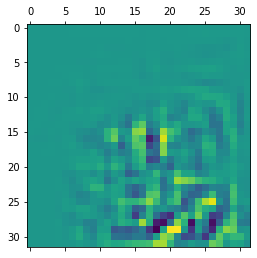

In [98]:
trans = transforms.ToPILImage()
heatmap = np.maximum(mixed, 0)
heatmap /= torch.max(heatmap)
plt.matshow(heatmap.squeeze())
# gradmap = trans(mixed[0])
# plt.imshow(trans(colorized[0]))

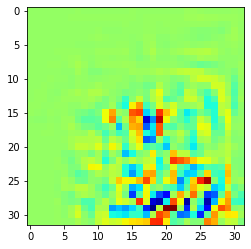

In [99]:
plt.imshow(trans(colorized[0]))

In [90]:
def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img*255)

def imshow(img):
    img = img / 2 + 0.49139968     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


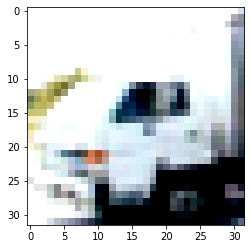

In [91]:
imshow(img)

In [85]:
	def overlay_heatmap(heatmap, image, alpha=0.5,
		colormap=cv2.COLORMAP_VIRIDIS):
		# apply the supplied color map to the heatmap and then
		# overlay the heatmap on the input image
		heatmap = cv2.applyColorMap(heatmap, colormap)
		output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
		# return a 2-tuple of the color mapped heatmap and the output,
		# overlaid image
		return (heatmap, output)

In [87]:
heatmap, output = overlay_heatmap(gradmap,img)

TypeError: Expected Ptr<cv::UMat> for argument 'src'

TypeError: Invalid shape (3, 32, 32) for image data

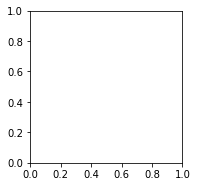

In [93]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(gradmap)


In [95]:
a = gradmap*mixed

TypeError: unsupported operand type(s) for *: 'Image' and 'Tensor'

In [145]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=